In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy.linalg import schur
from scipy.linalg import block_diag
import time
import torch
from scipy.stats import ortho_group
from data_.load_ts import give_ts, data_split_config

from module.unitary_dilation import dilation, check_if_can_dilate
from module.rc_class import RC
from module._rc_operations import reservoir

from module.process_ts import process_ts_slow

from module._rc_operations import cycle
from module.util import check_orthogonal, spec_radius, apply_P
from module.orthogonal_equiv import ortho_xform
from module.perfect_match_graph import approximateTu
from sklearn.metrics import mean_squared_error


In [2]:
n_res = 5
washout = 10 # same as look-back, memory tau, etc, 
# 15 -> 10 try
dilation_multiplier = 3


jumps = 10 # how many times we do the dilation

horizon = 300

randomize_iterations = 15

In [3]:
n_ts = 1
rc_nonlinear = 0

interval_len = washout
time_series_type = 'ettm2'
test_flag = 1


train_size, noise_length, test_size, train_size_conf = data_split_config(time_series_type, interval_len, 1)
validation_size = noise_length - train_size - interval_len -1 - test_size

noise_length_h = noise_length
noise_length += horizon
noise_length_conf = noise_length_h - interval_len
noise_length_h = noise_length - horizon

val_start = train_size + washout + 1

x_ts, noise_length = give_ts(name = time_series_type, n_ts = n_ts, noise_length = noise_length)
x_ts = (x_ts - x_ts.mean())/ x_ts.std()
data = x_ts[0]

test_flag = 1

# Threshold of whether we run MLP instead of ridge, seems like ridge is still faster

n_res_threshold = 100000

validation_flag = 0

spectral_radius = 0.9

In [4]:
if validation_flag == 1:
    val_start = train_size + washout +1
#     test_size_val = noise_length - val_start - test_size - horizon
    rang1  =range(val_start, noise_length - test_size-horizon )
else:
    val_start = train_size + washout +1  + validation_size
    rang1  =range(val_start, noise_length - horizon )

In [5]:
ts_pieces, y_pieces, val_pieces, y_val_pieces, test_pieces, y_test_pieces = process_ts_slow(x_ts, interval_len, train_size = train_size ,noise_length = noise_length_h, return_only_ts = 0, horizon = horizon, test_flag = test_flag, test_size = test_size)

In [6]:
_, V = reservoir(n_res,1, spectral_radius = spectral_radius)


Begin randomization

In [7]:
Full_dim_U = []
Full_dim_C = []
Full_results_unitary = []
Full_results_cyclic = []
Full_target_loss = []
Full_Wout_ll = []
Full_baseline = []
Full_state_norm = []
Full_state_norm_U = []
Full_Y_norm = []

In [8]:
for ii in tqdm(np.linspace(0,randomize_iterations,randomize_iterations + 1)):

    # Generate random W

    dilation_pass = False

    while not dilation_pass:

        S_test = ortho_group.rvs(n_res)
        T_test = ortho_group.rvs(n_res)
        D_test = np.random.random((n_res, 1))


        W_test = S_test @ np.diag(D_test.reshape(-1)) @ np.transpose(T_test)


        radius = spec_radius(W_test)
        W_test *= spectral_radius / radius

        if check_if_can_dilate(W_test):
            W = np.copy(W_test)
            dilation_pass = True

    check_if_can_dilate(W_test)
    model = RC(W, V,n_res_threshold = n_res_threshold)

    # Train initial Wout
    if validation_flag == 0: # in test set
        record_start = validation_size
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_test_pieces, 
                      'record_start': record_start, 'val_rec_size': test_size}
    else: #validation
        record_start = 0
        parameters = {'rc_nonlinear': rc_nonlinear, 'y_pieces': y_pieces, 'y_val_pieces': y_val_pieces, 
                      'record_start': record_start, 'val_rec_size': validation_size}

    X_target, Wout_ll, val_loss_rc_ll,val_loss_rc_mae_ll, Y_ll = model.core(data, train_size, washout, 
                                                                     noise_length_h, horizon = horizon, **parameters)
    target_loss = np.mean(val_loss_rc_ll)

    print(np.mean(val_loss_rc_ll))

    Full_target_loss.append(target_loss)
    Full_Wout_ll.append(Wout_ll)
    
    
    # BEGIN DILATION


    results_unitary = np.zeros(jumps)
    results_cyclic = np.zeros_like(results_unitary)
    results_perturb = np.zeros_like(results_unitary)
    results_norm = np.zeros_like(results_unitary)
    results_norm_U = np.zeros_like(results_unitary)
    results_Y = np.zeros_like(results_unitary)



    k = 0
    dilation_grid_points = np.linspace(-washout + 2, washout* dilation_multiplier + 2, jumps, dtype= int)
#     dilation_grid_points = np.linspace(-washout + 20, washout* dilation_multiplier, jumps, dtype= int)
    
#     dilation_grid_points = np.array([-8])

    U_dimensions = np.zeros_like(dilation_grid_points)
    C_dimensions = np.zeros_like(dilation_grid_points)

    for i in dilation_grid_points:

        dilation_N = washout + i

        # Construct Unitary Dilation
        Ur = dilation(W / spec_radius(W) , dilation_N, field = 'R')

        Tu, Ju = schur(Ur / spec_radius(Ur), output='real')

        Ur = spec_radius(W) * Tu
        Pu_choice = Ju.T

        V_u = np.append(V, np.zeros(Ur.shape[0] - n_res))
        V_u = V_u.reshape(-1,1)

        # Model of dilated version
        model_dilation = RC(spec_radius(W) * Tu, V_u, h = Wout_ll, n_original = n_res, n_res_threshold = n_res_threshold, P = Pu_choice)

        X_orth, _, val_loss_rc_ll,_, _ = model_dilation.core(data, train_size, washout, 
                                                                     noise_length_h, horizon = horizon, **parameters)

        val_loss_unitary = np.mean(val_loss_rc_ll)

        U_dimensions[k] = Ur.shape[0]
        results_unitary[k] = val_loss_unitary

        T_approx = approximateTu(Tu/spec_radius(Tu), epsilon = 0.01)
        if T_approx[1].shape[0] > 0:
            T_full = block_diag(*[T_approx[0], T_approx[1]])
        else:
            T_full = T_approx[0]

        dim_cyc = T_full.shape[0]
        C = cycle(dim_cyc, spectral_radius = 1)

        Tc, Jc = schur(C, output='real')
        assert np.allclose(Jc @ Tc @ Jc.T, C)

        # Find orthogonal transform:
        P_bar = ortho_xform(T_full,Tc)

        assert check_orthogonal(Jc)
        assert check_orthogonal(P_bar)
        assert np.allclose(P_bar @ T_full @ P_bar.T, Tc)


        V_full = np.append(V_u, np.zeros(T_full.shape[0] - Ur.shape[0]))
        V_full = V_full.reshape(-1,1)
        P_full = block_diag(*[Pu_choice, np.zeros([T_full.shape[0] - Ur.shape[0], T_full.shape[0] - Ur.shape[0]],int)])

        P_full = block_diag(*[Pu_choice, np.eye(T_full.shape[0] - Ur.shape[0])])

        P_c = Jc @ P_bar @ P_full


        model_circular = RC(spec_radius(W) *  C , V_full, h = Wout_ll, n_original = n_res, 
                        n_res_threshold = n_res_threshold, P = P_c)

        X_cyclic, _, val_lost_cyclic_ll,_, Y_cyclic = model_circular.core(data, train_size, 
                                                        washout, noise_length_h, 
                                                        horizon = horizon, **parameters)


        val_loss_cyclic = np.mean(val_lost_cyclic_ll)

        results_cyclic[k] = val_loss_cyclic
        C_dimensions[k] = C.shape[0]
        
        # 2-norm of states
        X_orth_new = np.apply_along_axis(apply_P, 0, X_orth, Pu_choice, n_res)
        X_cyclic_new = np.apply_along_axis(apply_P, 0, X_cyclic, P_c, n_res)
        
        state_norm = np.zeros(X_target.shape[1])
        state_norm_orth = np.zeros_like(state_norm)

        for i in range(X_target.shape[1]):
            state_norm[i] = np.linalg.norm(X_cyclic_new[:,i] - X_target[:,i])
            state_norm_orth[i] = np.linalg.norm(X_orth_new[:,i] - X_target[:,i])

        results_norm[k] = np.mean(state_norm)
        results_norm_U[k] = np.mean(state_norm_orth)
        
        # Y diff
        
        Y_diff = np.zeros(Y_ll.shape[1])
        
        for i in range(X_target.shape[1]):
            Y_diff[i] = np.linalg.norm(Y_cyclic[:,i] - Y_ll[:,i])

        results_Y[k]  = np.mean(Y_diff)
        
        results_norm[k] = mean_squared_error(X_cyclic_new, X_target)
        results_Y[k] = mean_squared_error(Y_cyclic, Y_ll)
        
        k += 1
        # print(np.mean(val_loss_rc_ll))

    Full_dim_U.append(U_dimensions)
    Full_dim_C.append(C_dimensions)
    Full_results_unitary.append(results_unitary)
    Full_results_cyclic.append(results_cyclic)
    Full_state_norm.append(results_norm)
    Full_state_norm_U.append(results_norm_U)
    Full_Y_norm.append(results_Y)


  0%|                                                                                                                                      | 0/16 [00:00<?, ?it/s]

0.581452655968782


  6%|███████▉                                                                                                                      | 1/16 [00:51<12:48, 51.21s/it]

0.5827690219133156


 12%|███████████████▊                                                                                                              | 2/16 [01:48<12:50, 55.05s/it]

0.5675105067983198


 19%|███████████████████████▋                                                                                                      | 3/16 [02:40<11:35, 53.53s/it]

0.5825343506931002


 25%|███████████████████████████████▌                                                                                              | 4/16 [03:35<10:46, 53.90s/it]

0.5798479329172396


 31%|███████████████████████████████████████▍                                                                                      | 5/16 [04:30<09:59, 54.49s/it]

0.5816034780227081


 38%|███████████████████████████████████████████████▎                                                                              | 6/16 [05:14<08:26, 50.70s/it]

0.5712303895628629


 44%|███████████████████████████████████████████████████████▏                                                                      | 7/16 [06:01<07:27, 49.71s/it]

0.5826376699643901


 50%|███████████████████████████████████████████████████████████████                                                               | 8/16 [06:49<06:32, 49.04s/it]

0.5808688851355184


 56%|██████████████████████████████████████████████████████████████████████▉                                                       | 9/16 [07:47<06:03, 51.97s/it]

0.5680489818709133


 62%|██████████████████████████████████████████████████████████████████████████████▏                                              | 10/16 [08:50<05:32, 55.46s/it]

0.5673661610345277


 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 11/16 [09:50<04:43, 56.73s/it]

0.5714029891607753


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 12/16 [10:54<03:55, 58.88s/it]

0.5706804937745587


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 13/16 [11:49<02:53, 57.72s/it]

0.5824346531938569


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 14/16 [12:44<01:53, 56.81s/it]

0.5800018646673444


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 15/16 [13:29<00:53, 53.30s/it]

0.5774223198831325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [14:32<00:00, 54.52s/it]


In [9]:
dilation_grid_points + washout

array([ 2,  6, 10, 15, 19, 24, 28, 33, 37, 42])

In [10]:
Full_dim_U = np.array(Full_dim_U)
Full_dim_C = np.array(Full_dim_C)
Full_results_unitary = np.array(Full_results_unitary)
Full_results_cyclic = np.array(Full_results_cyclic)
Full_target_loss = np.array(Full_target_loss)
Full_Wout_ll = np.array(Full_Wout_ll)
Full_state_norm = np.array(Full_state_norm)
Full_state_norm_U = np.array(Full_state_norm_U)
Full_Y_norm = np.array(Full_Y_norm)

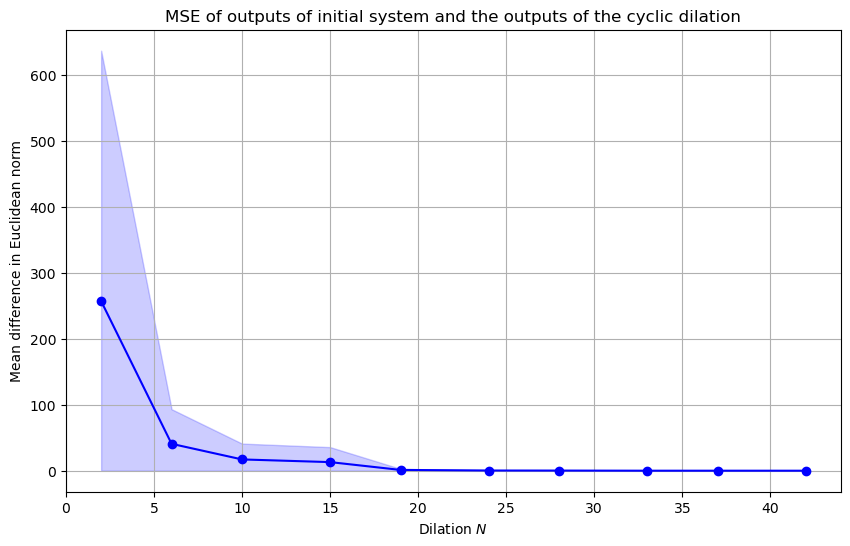

In [11]:
data = Full_Y_norm
time_steps = dilation_grid_points + washout

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

# time_steps = np.arange(data.shape[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, means, marker='o', linestyle='-', color='b', label='Mean')
plt.fill_between(time_steps, np.maximum(np.zeros_like(means), means - 1.96 * sem), means + 1.96 * sem, color='b', alpha=0.2, label='95% CI')


plt.xlabel('Dilation $N$')
plt.ylabel('Mean difference in Euclidean norm')
# plt.yscale('log')
plt.title('MSE of outputs of initial system and the outputs of the cyclic dilation')
# plt.legend()
plt.grid(True)

plt.savefig('./results/Y_norm.pdf')
plt.show()




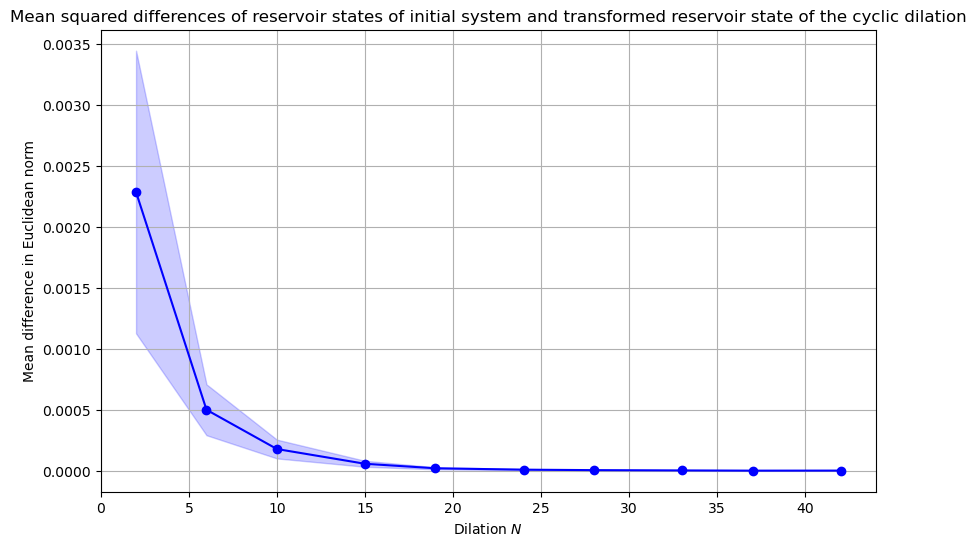

In [12]:
data = Full_state_norm
time_steps = dilation_grid_points + washout

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

# time_steps = np.arange(data.shape[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, means, marker='o', linestyle='-', color='b', label='Mean')
plt.fill_between(time_steps, means - 1.96 * sem, means + 1.96 * sem, color='b', alpha=0.2, label='95% CI')


plt.xlabel('Dilation $N$')
plt.ylabel('Mean difference in Euclidean norm')
# plt.yscale('log')
plt.title('Mean squared differences of reservoir states of initial system and transformed reservoir state of the cyclic dilation')
# plt.legend()
plt.grid(True)

plt.savefig('./results/state_norm.pdf')
plt.show()




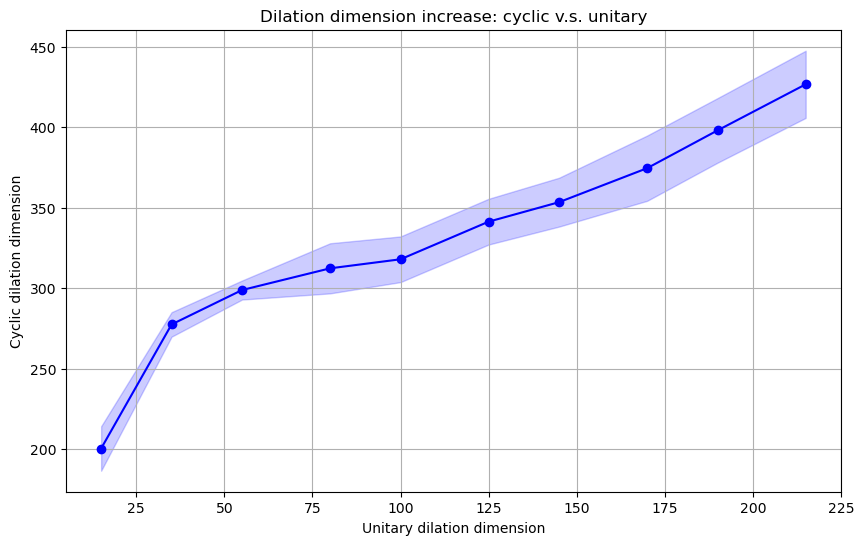

In [13]:
data = Full_dim_C

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

# time_steps = np.arange(data.shape[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(U_dimensions, means, marker='o', linestyle='-', color='b', label='Mean')
plt.fill_between(U_dimensions, means - 1.96 * sem, means + 1.96 * sem, color='b', alpha=0.2, label='95% CI')

plt.xlabel('Unitary dilation dimension')
plt.ylabel('Cyclic dilation dimension')
plt.title('Dilation dimension increase: cyclic v.s. unitary')
# plt.legend()
plt.grid(True)

plt.savefig('./results/dilation_dimension.pdf')
plt.show()


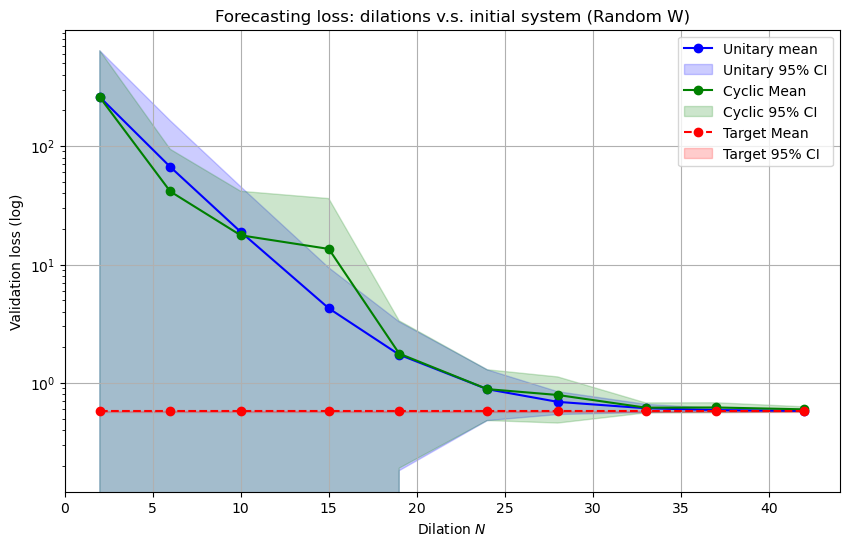

In [14]:
data = Full_results_unitary

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

time_steps = np.arange(data.shape[1])
time_steps = dilation_grid_points + washout

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, means, marker='o', linestyle='-', color='b', label='Unitary mean')
plt.fill_between(time_steps, means - 1.96 * sem, means + 1.96 * sem, color='b', alpha=0.2, label='Unitary 95% CI')

data = Full_results_cyclic

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

plt.plot(time_steps, means, marker='o', linestyle='-', color='g', label='Cyclic Mean')
plt.fill_between(time_steps, means - 1.96 * sem, means + 1.96 * sem, color='g', alpha=0.2, label='Cyclic 95% CI')

# plt.plot(time_steps, target_loss*np.ones_like(dilation_grid_points), 'r--', alpha=0.5, label = 'Initial system (baseline)')

data = Full_target_loss

means = np.mean(data, axis=0)
sem = np.std(data, axis=0) / np.sqrt(data.shape[0])

plt.plot(time_steps, means*np.ones_like(dilation_grid_points), marker='o', linestyle='--', color='r', label='Target Mean')
plt.fill_between(time_steps, (means - 1.96 * sem)*np.ones_like(dilation_grid_points), 
                 (means + 1.96 * sem)*np.ones_like(dilation_grid_points), color='r', alpha=0.2, label='Target 95% CI')

plt.title('Forecasting loss: dilations v.s. initial system (Random W)')
plt.yscale('log')
plt.ylabel('Validation loss (log)')
plt.xlabel('Dilation $N$')
plt.legend()
plt.grid(True)

plt.savefig('./results/CI_forecasting_loss.pdf')
plt.show()


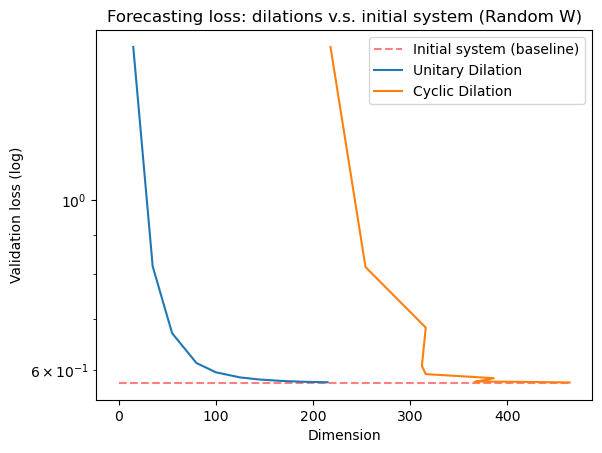

In [15]:
plt.plot(range(0,np.max(C_dimensions)), target_loss*np.ones_like(range(0,np.max(C_dimensions))), 'r--', alpha=0.5, label = 'Initial system (baseline)')
plt.plot(U_dimensions, results_unitary, label = 'Unitary Dilation')

# plt.plot(C_dimensions[ind_C], results_cyclic[ind_C], label = 'Cyclic Dilation')
plt.plot(C_dimensions, results_cyclic, label = 'Cyclic Dilation')

plt.title('Forecasting loss: dilations v.s. initial system (Random W)')
plt.yscale('log')
plt.ylabel('Validation loss (log)')
plt.xlabel('Dimension')
plt.legend()
plt.savefig('./results/one_compare.pdf')
